In [1]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from minisom import MiniSom
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import psutil
import warnings
import tracemalloc

In [18]:
# Inizializzazione del dataset e dei parametri
DATA_PATH = "/users/mik2002/som/dataset-processed CIC-IDS-2018/"
FILES = ["processed_bruteforce_dataset.csv"]
df_dataset = pd.concat([pd.read_csv(DATA_PATH + file) for file in FILES], ignore_index=True)

In [19]:
df_dataset['Label'].value_counts()

Label
Benign        664002
Bruteforce    156668
Name: count, dtype: int64

In [32]:
sampled_df = df_dataset.groupby("Label").apply(lambda x: x.sample(frac=0.1, random_state=42))
sampled_df["Label"] = sampled_df["Label"].map({"Benign": 0,"Bruteforce":1})

/tmp/ipykernel_248044/2779833879.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df_dataset.groupby("Label").apply(lambda x: x.sample(frac=0.1, random_state=42))


In [33]:
sampled_df['Label'].value_counts()

Label
0    66400
1    15667
Name: count, dtype: int64

In [34]:
# split dataset in data and target 
target = sampled_df.iloc[:len(sampled_df),-1].values
data = sampled_df.iloc[:len(sampled_df),:-1]

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [36]:
# split data in Training and Testing set
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(data, target,test_size=0.2)
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing  set has {} samples.".format(X_test.shape[0]))

Training set has 65653 samples.
Testing  set has 16414 samples.


In [37]:
# since this in supervised classification not unsupervised, this function chooses the class of
# the BMU to be the final class of each instance
def classify(som, data):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = som.labels_map(X_train, y_train)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [38]:
# set hyperparameters
n_neurons = 20
m_neurons = 20
input_len = X_train.shape[1]
sigma = 1.5
learning_rate = 1.2
iterations = 10000

In [43]:
from minisom import MiniSom
# initialization
som = MiniSom(x=n_neurons, y=m_neurons,input_len=input_len,sigma=sigma,learning_rate=learning_rate)

In [40]:
%%time
som.train(X_train, iterations, verbose=True)  # random training

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.5016599163253286
CPU times: user 8.79 s, sys: 322 ms, total: 9.12 s
Wall time: 3.43 s


In [41]:
%%time
y_pred = classify(som, X_test)
report = classification_report(y_test, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9997    0.9992    0.9995     13318
           1     0.9968    0.9987    0.9977      3096

    accuracy                         0.9991     16414
   macro avg     0.9982    0.9990    0.9986     16414
weighted avg     0.9991    0.9991    0.9991     16414

CPU times: user 7.34 s, sys: 0 ns, total: 7.34 s
Wall time: 7.34 s


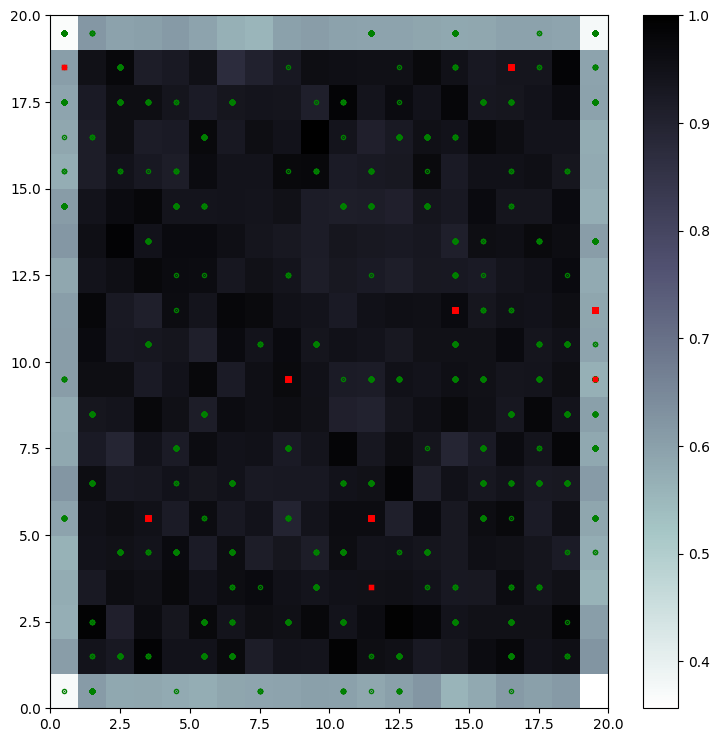

CPU times: user 1min 30s, sys: 1.64 s, total: 1min 32s
Wall time: 1min 32s


In [44]:
%%time
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the processed_friday_dataset
# different colors and markers for each label
markers = ['o', 's']
colors = ['g', 'r']

for cnt, xx in enumerate(data):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]], markerfacecolor=colors[target[cnt]],
             markeredgecolor=colors[target[cnt]], markersize=1, markeredgewidth=3)


plt.show()